In [1]:
!pip install pylops

## Complex MatMul problem, two ways

Let's first define the forward problem

$$
y = Ax
$$

where x is real, A is complex and y is complex. With an abuse of notation we can write

$$
y_r + jy_i = A_r * x + j(A_i * x)
$$

We can now just solve the first problem

$$
x = A^{-1} y
$$

or divide it into two set of equations, one for real and one for complex (after all x is real so there is no 'cross-talk':

$$
A_1 = [A_r, A_i]^T \quad y_1 = [y_r, y_i]^T \quad 
$$

and then write

$$
x = A_1^{-1} y_1
$$

This proves the two solutions are identical. We will also verify it numerically.

Finally note that if we write the normal equations we have

$$
x = (A_r^TA_r + A_i^TA_i)^{-1} (A_r^Ty_r + A_i^Ty_i)
$$

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.solver import cgls

from pylops import LinearOperator

In [3]:
n = 100

x = np.arange(n) + 1.

# make A
Ar = np.random.normal(0, 1, (n, n))
Ai = np.random.normal(0, 1, (n, n))
A = Ar + 1j * Ai

Aop = MatrixMult(A)

# make y first eq
y = Aop @ x

# make y second eq
y_ = MatrixMult(Ar) @ x + 1j * MatrixMult(Ai) @ x

np.allclose(y, y_)

True

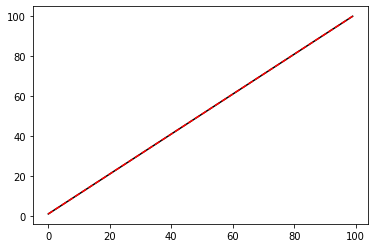

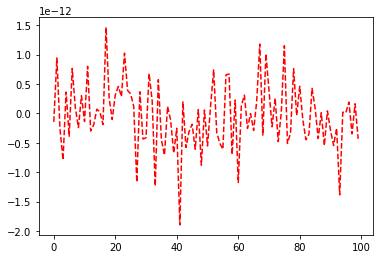

In [4]:
# invert x third eq
xinv = Aop.div(y)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv), '--r')

plt.figure()
plt.plot(np.imag(xinv), '--r');

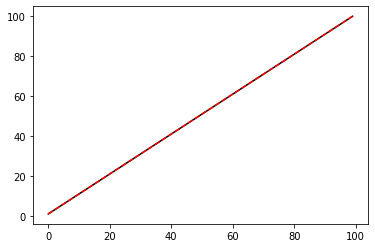

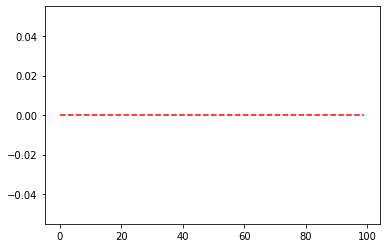

In [5]:
# invert x 4-5 eqs
y1 = np.concatenate([np.real(y), np.imag(y)])
A1op = VStack([MatrixMult(np.real(A)), MatrixMult(np.imag(A))])

xinv1 = A1op.div(y1)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv1), '--r')

plt.figure()
plt.plot(np.imag(xinv1), '--r');

So far so good, even when using PyLops.. but we have cheated as we have a dense matrix and can take its real and imag parts and write eq 4-5.

But what about if we dont know the entries of the matrix/operator... we only know that it takes a real number and produces a complex (whilst its adjoint takes a complex and produces a real.

First we do something similar to eq3 and use the fact we can manipulate the adjoint to make it real.

In [6]:
class MatMult_cmpx(LinearOperator):
    def __init__(self, A, dtype='float64'):
        self.A = A
        self.shape = A.shape
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matvec(self, x):
        y = A @ x
        return y

    def _rmatvec(self, x):
        y = np.real(np.conj(A.T) @ x)
        return y

In [7]:
Aop = MatMult_cmpx(A)
for complexflag in range(4):
  if complexflag == 0:
    print("Both model and data are real    :", end=' ')
  elif complexflag == 1:
    print("Only data is real               :", end=' ')
  elif complexflag == 2:
    print("Only model is real              :", end=' ')
  elif complexflag == 3:
    print("Neither data nor model are real :", end=' ')
  try:
    dottest(Aop, n, n, complexflag=complexflag)
    print("pass")
  except ValueError:
    print("fail")

Both model and data are real    : fail
Only data is real               : fail
Only model is real              : pass
Neither data nor model are real : fail


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


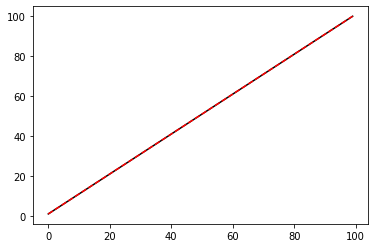

In [8]:
# invert x third eq (with guaranteed 0 imag component)
xinv = Aop.div(y)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv), '--r')

print(np.imag(xinv))

Next we try to work with real and imag parts separately as in eq4 and eq5

In [9]:
class MatMult_cmpx(LinearOperator):
    def __init__(self, A, real=True, dtype='float64'):
        self.A = A
        self.shape = A.shape
        self.dtype = np.dtype(dtype)
        self.explicit = False
        
        self.real = real
        self.xprev = None
        self.yprev = None
            
        self.neval = 0 # number of evaluations of the operator
        
    def _matvec(self, x):
        y = A @ x # forward (can be any!)
        self.neval += 1
        if self.real:
            y = np.real(A @ x)
        else:
            y = np.imag(A @ x)
        return y

    def _rmatvec(self, y):
        x = np.conj(A.T) @ y # adjoint (can be any!)
        self.neval += 1
        if self.real:
            x = np.real(x)
        else:
            # - is require because we want the result of the imag component of A and y, 
            # but since we conjugated
            x = -np.imag(x) 
        return x

In [10]:
Arop = MatMult_cmpx(A, real=True)
Aiop = MatMult_cmpx(A, real=False)

dottest(Arop, n, n, complexflag=0, verb=True)
dottest(Aiop, n, n, complexflag=0, verb=True)

Dot test passed, v^T(Opu)=-125.854604 - u^T(Op^Tv)=-125.854604
Dot test passed, v^T(Opu)=-19.359276 - u^T(Op^Tv)=-19.359276


True

43 43 86


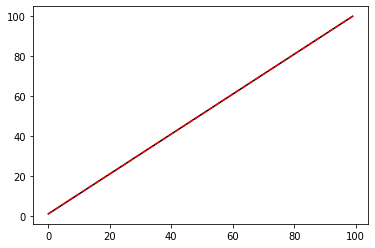

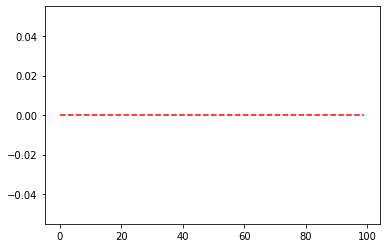

In [11]:
# invert x 4-5 eqs
y1 = np.concatenate([np.real(y), np.imag(y)])

Arop = MatMult_cmpx(A, real=True)
Aiop = MatMult_cmpx(A, real=False)
A1op = VStack([Arop, Aiop])

xinv1 = cgls(A1op, y1, np.zeros(n), niter=20)[0]

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv1), '--r')

plt.figure()
plt.plot(np.imag(xinv1), '--r')

print(Arop.neval, Aiop.neval, Arop.neval + Aiop.neval)

This is inefficient, at every iteration we need to perform 2 forwards and 2 adoints (one for the real and one for the imag part).

We need something to tell the operator that the operation has been already performed, to simply compute the real or imag part...

In [12]:
class _RealImagLinearOperator(LinearOperator):
    """Real-Imag linear operator
    """
    def __init__(self, Op, real=True):
        if not isinstance(Op, spLinearOperator):
            raise TypeError('Op must be a LinearOperator')
        super(_RealImagLinearOperator, self).__init__(Op, Op.shape)
        self.Op = Op
        self.real = real
        
    def _matvec(self, x):
        y = self.Op._matvec(x)
        if self.real:
            y = np.real(y)
        else:
            y = np.imag(y)
        return y
        
    def _rmatvec(self, y):
        x = self.Op._rmatvec(y)
        if self.real:
            x = np.real(x)
        else:
            x = -np.imag(x)
        return x

In [13]:
class LinearOperator1(LinearOperator):
    def real(self):
        realimagop = _RealImagLinearOperator(self)
        return realimagop
    def imag(self):
        realimagop = _RealImagLinearOperator(self, False)
        return realimagop

In [14]:
class MatMult_memoize(LinearOperator1):
    def __init__(self, A, real=True, dtype='float64'):
        self.A = A
        self.shape = A.shape
        self.dtype = np.dtype(dtype)
        self.explicit = False
        
        self.xprev = np.zeros(self.shape[0], dtype=self.dtype)
        self.yprev = np.zeros(self.shape[1], dtype=self.dtype)
        self.neval = 0 # number of evaluations of the operator
        
    def _matvec(self, x):
        if np.allclose(self.xprev, x):
            y = self.yprev
        else:    
            y = A @ x # forward
            self.neval += 1
        self.xprev = x.copy()
        self.yprev = y.copy()
        return y

    def _rmatvec(self, y):
        if np.allclose(self.yprev, y):
            x = self.xprev
        else: 
            x = np.conj(A.T) @ y # adjoint
            self.neval += 1
        self.xprev = x.copy()
        self.yprev = y.copy()
        return x

In [15]:
Amop = MatMult_memoize(A)
Arop = Amop.real()
Aiop = Amop.imag()

dottest(Arop, n, n, complexflag=0, verb=True)
dottest(Aiop, n, n, complexflag=0, verb=True)

Dot test passed, v^T(Opu)=30.043909 - u^T(Op^Tv)=30.043909
Dot test passed, v^T(Opu)=-70.009124 - u^T(Op^Tv)=-70.009124


True

In [16]:
# Let's check our counter works
Amop = MatMult_memoize(A)

Amop * np.ones(n) # 1st
print(Amop.neval)
Amop * np.ones(n) # same
print(Amop.neval)
Amop * np.zeros(n) # new
print(Amop.neval)

Amop.H * np.ones(n) # 1st
print(Amop.neval)
Amop.H * np.ones(n) # new
print(Amop.neval)
Amop.H * np.zeros(n) # new
print(Amop.neval)

1
1
2
3
3
4


In [17]:
Amop = MatMult_memoize(A)
Arop = Amop.real()
Aiop = Amop.imag()

A1op = VStack([Arop, Aiop])

A1op * np.ones(n) # 1st
print(Amop.neval)
A1op * np.ones(n) # same
print(Amop.neval)
A1op * np.ones(n) # new
print(Amop.neval)

A1op.H * np.ones(2*n) # 1st
print(Amop.neval)
A1op.H * np.ones(2*n) # same
print(Amop.neval)
A1op.H * np.ones(2*n) # new
print(Amop.neval)

1
1
1
2
2
2


63


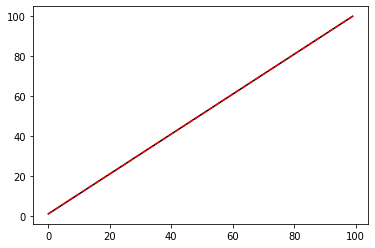

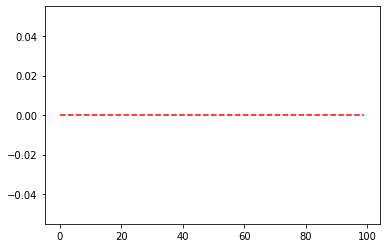

In [18]:
Amop = MatMult_memoize(A)
Arop = Amop.real()
Aiop = Amop.imag()

A1op = VStack([Arop, Aiop])
y1 = np.concatenate([np.real(y), np.imag(y)])
xinv1 = cgls(A1op, y1, np.zeros(n), niter=20)[0]

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv1), '--r')

plt.figure()
plt.plot(np.imag(xinv1), '--r')

print(Amop.neval)

Less than before, but I still think it should be less... one 41 (1 forw and 1 adj per iter plus one at start)

In [19]:
class MemoizeOperator(LinearOperator):
    def __init__(self, Op, max_neval=10):
        self.Op = Op
        self.shape = Op.shape
        self.dtype = np.dtype(Op.dtype)
        self.explicit = False

        self.max_neval = max_neval # Maximum number of evaluations, use np.inf for infinite memory
        self.store = [] # Store a list of Tuples (x, y)
        self.neval = 0 # Number of evaluations of the operator
        
    def _matvec(self, x):
        for xstored, ystored in self.store:
            if np.allclose(xstored, x):
                return ystored
        y = A @ x
        self.neval += 1
        self.store.append((x.copy(), y.copy()))
        if len(self.store) > self.max_neval:
            del self.store[0] # Delete oldest
        
        return y

    def _rmatvec(self, y):
        for xstored, ystored in self.store:
            if np.allclose(ystored, y):
                return ystored
        x = np.conj(self.Op.T) @ y
        self.neval += 1
        self.store.append((x.copy(), y.copy()))
        if len(self.store) > self.max_neval:
            del self.store[0] # Delete oldest

        return x

In [21]:
Amem = MemoizeOperator(A, max_neval=2)

print(Amem.neval)
Amem * np.ones(n) # 1st
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)
Amem * (2*np.ones(n)) # new
print(Amem.neval)
Amem * (2*np.ones(n)) # same
print(Amem.neval)
Amem * (3*np.ones(n)) # new, bumped np.ones(n) from memory
print(Amem.neval)
Amem * np.ones(n) # new, bumped 2*np.ones(n) from memory
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)

0
1
1
1
2
2
3
4
4
